# InstructGoose

> Implementation of Reinforcement Learning from Human Feedback (RLHF) from the InstructGPT paper

[<img src="https://img.shields.io/badge/license-MIT-blue">](https://github.com/xrsrke/instructGOOSE)
[![tests](https://github.com/vwxyzjn/cleanrl/actions/workflows/tests.yaml/badge.svg)](https://github.com/xrsrke/instructGOOSE/actions/workflows/tests.yaml)
[![docs](https://img.shields.io/github/deployments/vwxyzjn/cleanrl/Production?label=docs&logo=vercel)](https://xrsrke.github.io/instructGOOSE/)
[![Code style: black](https://img.shields.io/badge/code%20style-black-000000.svg)](https://github.com/psf/black)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1HN1t75Jem9jXPzaOQdQO06OXMxinimNx?usp=sharing)
<!-- [![Imports: isort](https://img.shields.io/badge/%20imports-isort-%231674b1?style=flat&labelColor=ef8336)](https://pycqa.github.io/isort/) -->

Paper: InstructGPT - [Training language models to follow instructions with human feedback](https://arxiv.org/abs/2203.02155)

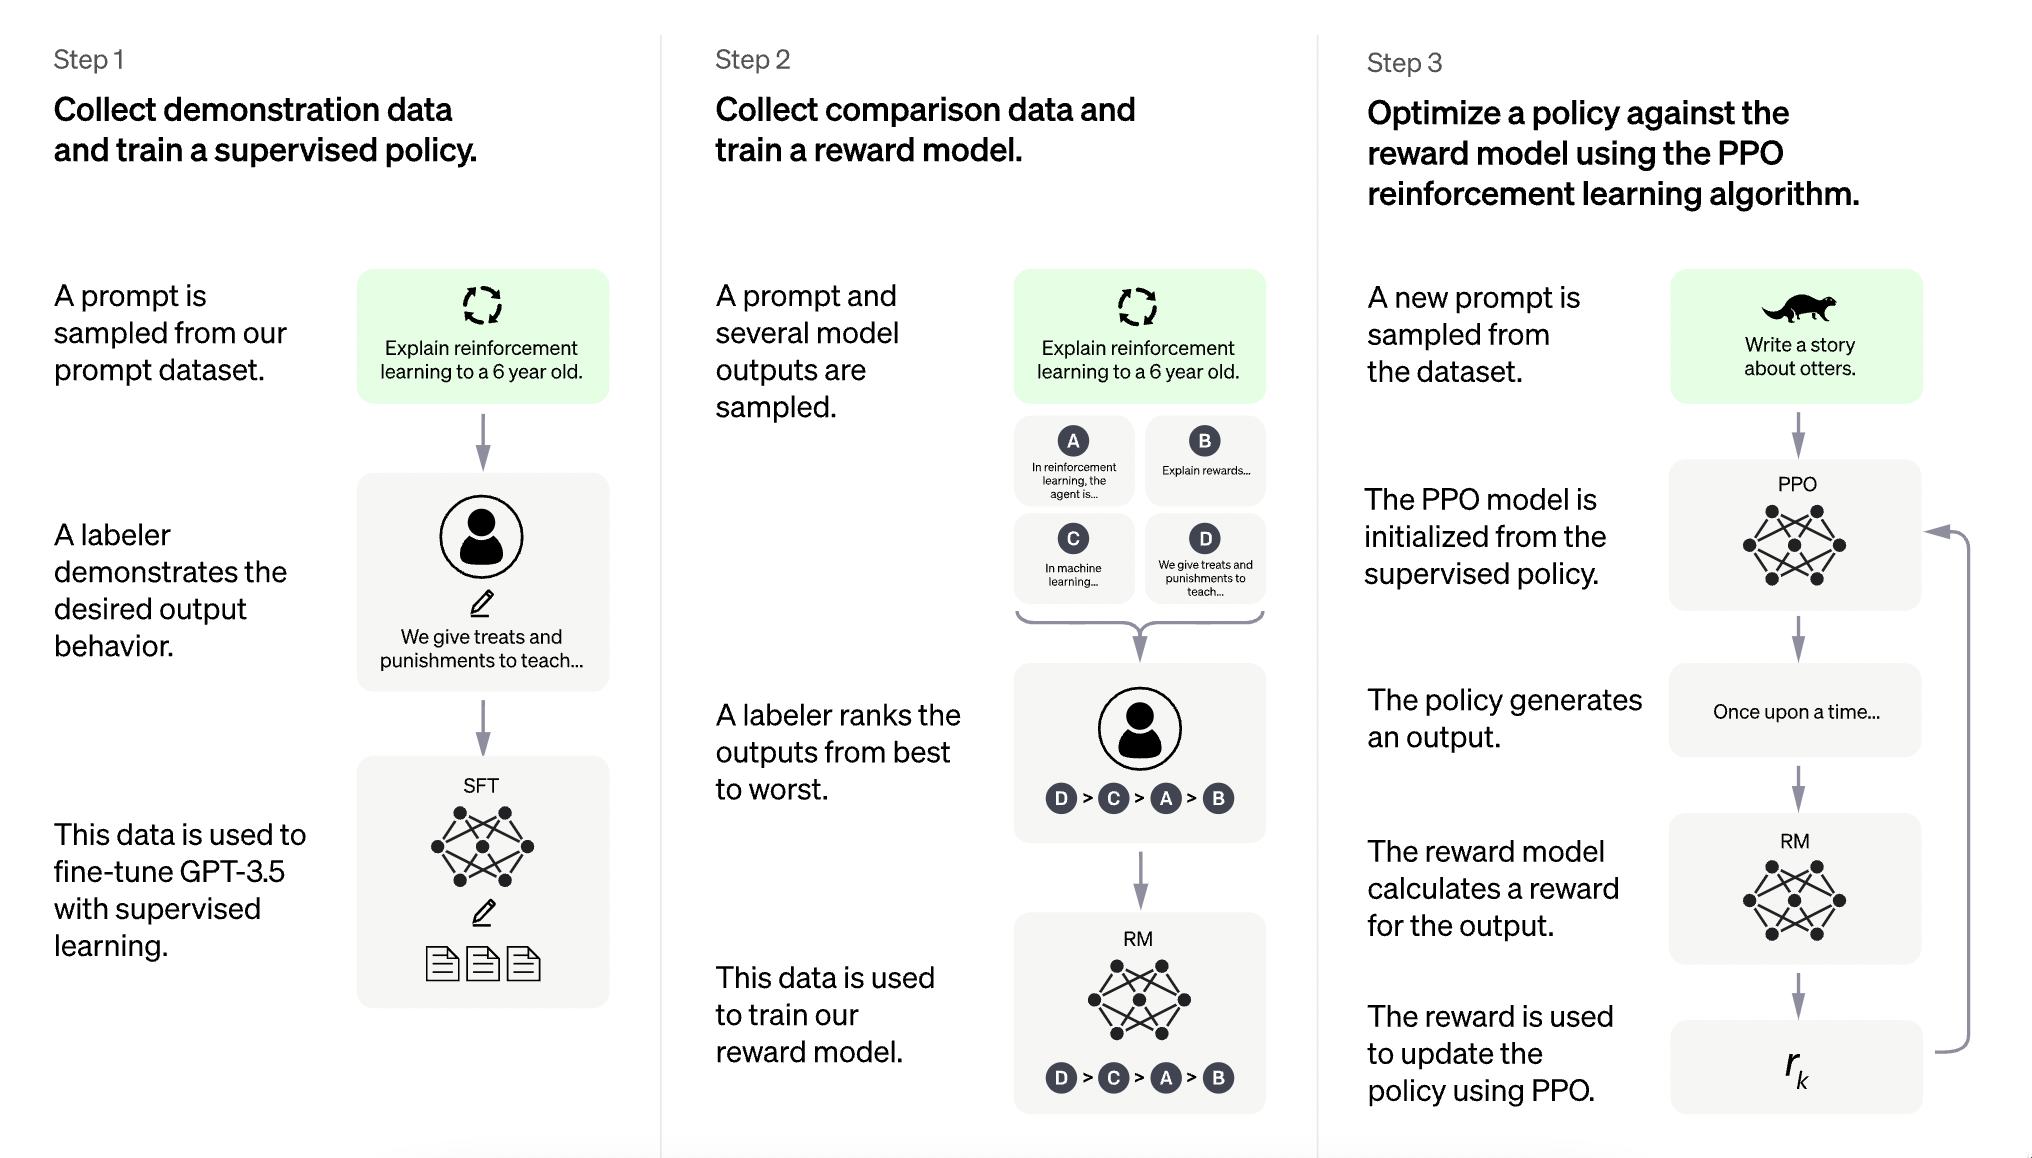

## Install

Install from PipPy

```sh
pip install instruct-goose
```

Install directly from the source code

```sh
git clone https://github.com/xrsrke/instructGOOSE.git
cd instructGOOSE
pip install -e .
```

### How to Train

**For reward model**

Use 🤗 Accelerate to launch distributed training

```bash
accelerate config
accelerate launch scripts/train_reward.py
```

## Train the RL-based language model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

import torch
from torch.utils.data import DataLoader, random_split
from torch import optim

from instruct_goose import Agent, RewardModel, RLHFTrainer, RLHFConfig, create_reference_model

**Step 1:** Load dataset

In [ ]:
dataset = load_dataset("imdb", split="train")
dataset, _ = random_split(dataset, lengths=[10, len(dataset) - 10]) # for demenstration purposes
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

Found cached dataset imdb (/Users/education/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


**Step 2**: Load the pre-trained model and tokenizer

In [ ]:
model_base = AutoModelForCausalLM.from_pretrained("gpt2") # for demonstration purposes
reward_model = RewardModel("gpt2")

tokenizer = AutoTokenizer.from_pretrained("gpt2", padding_side="left")
eos_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

**Step 3**: Create the RL-based language model agent and the reference model

In [ ]:
model = Agent(model_base)
ref_model = create_reference_model(model)

**Step 4**: Train it

In [ ]:
max_new_tokens = 20
generation_kwargs = {
    "min_length":-1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": max_new_tokens
}

config = RLHFConfig()
N_EPOCH = 1 # for demonstration purposes
trainer = RLHFTrainer(model, ref_model, config)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(N_EPOCH):
    for batch in train_dataloader:
        inputs = tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")
        response_ids = model.generate(
            inputs["input_ids"], attention_mask=inputs["attention_mask"],
            **generation_kwargs
        )
        
        # extract the generated text
        response_ids = response_ids[:, -max_new_tokens:]
        response_attention_mask = torch.ones_like(response_ids)
        
        # evaluate from the reward model
        with torch.no_grad():
            text_input_ids = torch.stack([torch.concat([q, r]) for q, r in zip(inputs["input_ids"], response_ids)], dim=0)
            rewards = reward_model(text_input_ids)
        
        # calculate PPO loss
        loss = trainer.compute_loss(
            query_ids=inputs["input_ids"],
            query_attention_mask=inputs["attention_mask"],
            response_ids=response_ids,
            response_attention_mask=response_attention_mask,
            rewards=rewards
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss={loss}")

loss=-824.6560668945312
loss=0.030958056449890137
loss=4.284017562866211


## TODO

- Add support custom reward function
- Add support custom value function
- Add support non-transformer models
- Write config class

✅ Distributed training using 🤗 Accelerate

## Resources
I implemented this using these resources

- Copied the `load_yaml` function from https://github.com/Dahoas/reward-modeling
- How to build a dataset to train reward model: https://wandb.ai/carperai/summarize_RLHF/reports/Implementing-RLHF-Learning-to-Summarize-with-trlX--VmlldzozMzAwODM2
- How to add value head in PPO agent: https://github.com/lvwerra/trl
- How to calculate the loss of PPO agent: https://github.com/lvwerra/trl/blob/main/trl/trainer/ppo_trainer.py
- How to use PPO to train RLHF agent: https://github.com/voidful/TextRL
- How PPO works: https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py
- Copied the compute `advantages` and `returns` from `TLR`: https://github.com/lvwerra/trl/blob/d2e8bcf8373726fb92d2110c500f7df6d0bd566d/trl/trainer/ppo_trainer.py#L686